In [1]:
from pathlib import Path
import matplotlib as mpl
import xarray as xr

In [2]:
from pathlib import Path

from bs_fdbck_clean.util.BSOA_datamanip import ds2df_inc_preprocessing
from bs_fdbck_clean.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck_clean.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log

from bs_fdbck_clean.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [3]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model

In [4]:
from bs_fdbck_clean.constants import path_measurement_data
select_station = 'SMR'
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /'SMEARII'/'processed'

In [5]:
path_comb_data_full_time =postproc_data_obs /'SMEAR_data_comb_hourly.csv'

In [6]:
plot_path = Path(f'Plots/{select_station}')

In [7]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalNx_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

In [8]:
plot_path.mkdir(exist_ok=True, parents=True)

## Read in model data. 

In [9]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [10]:
from bs_fdbck_clean.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck_clean.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck_clean.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck_clean.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
import numpy as np

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

# Functions:

In [14]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [15]:
import pandas as pd

## Read in model data

In [16]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv
UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_UKESM_AEROCOMTRAJ.csv


### Check UKESM 

In [17]:
dic_df_pre['UKESM']['AEROCOMTRAJ'].columns

Index(['lev', 'station', 'Mass_Conc_OM_AS', 'Mass_Conc_OM_CS',
       'Mass_Conc_OM_KI', 'Mass_Conc_OM_KS', 'Mass_Conc_OM_NS', 'T', 'ddryAS',
       'ddryCS', 'ddryKI', 'ddryKS', 'ddryNS', 'mmrtr_OM_AS', 'mmrtr_OM_CS',
       'mmrtr_OM_KI', 'mmrtr_OM_KS', 'mmrtr_OM_NS', 'nconcAS', 'nconcCS',
       'nconcKI', 'nconcKS', 'nconcNS', 'nconcAS_uncorrected',
       'nconcCS_uncorrected', 'nconcKI_uncorrected', 'nconcKS_uncorrected',
       'nconcNS_uncorrected', 'SFisoprene', 'SFterpene', 'N50_amb', 'N70',
       'N100_amb', 'N150', 'N200_amb', 'N500', 'N50-500', 'N70-500',
       'N100-500', 'N150-500', 'N200-500', 'OA_amb', 'T_C', 'is_JJA', 'is_JA',
       'isSummer', 'density', 'ambient2stp_correction_factor', 'OA_STP',
       'N100_STP', 'N200_STP', 'N50_STP'],
      dtype='object')

In [18]:
df_test = dic_df_pre['UKESM']['AEROCOMTRAJ']#['nconcAS']
df_test['nconc'] = 0
for v in ['nconcAS', 'nconcCS','nconcKI', 'nconcKS', 'nconcNS']:
    df_test['nconc'] += df_test[v]

In [19]:
df_test = dic_df_pre['UKESM']['AEROCOMTRAJ']#['nconcAS']
df_test['OAnconc'] = 0
for v in [ 'Mass_Conc_OM_AS', 'Mass_Conc_OM_CS',
       'Mass_Conc_OM_KI', 'Mass_Conc_OM_KS', 'Mass_Conc_OM_NS']:
    df_test['OAnconc'] += df_test[v]

<AxesSubplot:xlabel='time'>

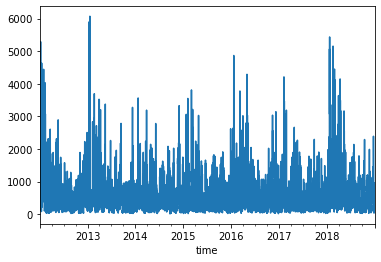

In [20]:
df_test['nconc'].plot()

<AxesSubplot:xlabel='month'>

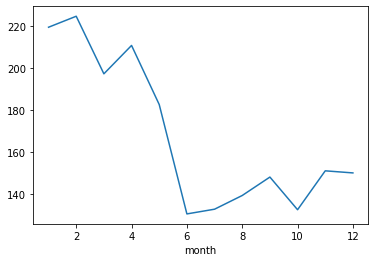

In [21]:
df_test['month'] = df_test.index.month
(1/3*df_test['nconc'].groupby(df_test['month']).mean()).plot()
#(df_test['nconc'].groupby(df_test['month']).mean()).plot()

<AxesSubplot:xlabel='month'>

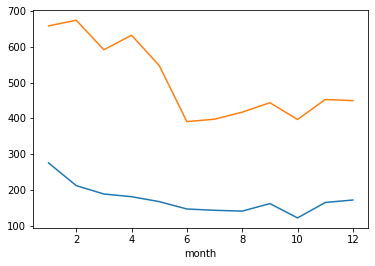

In [22]:
df_test['month'] = df_test.index.month
_df = df_test['2012':'2014']
(1/3*_df['nconc'].groupby(_df['month']).mean()).plot()
(df_test['nconc'].groupby(df_test['month']).mean()).plot()

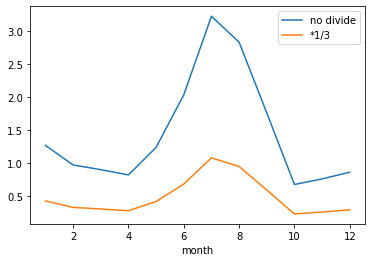

In [24]:
df_test['month'] = df_test.index.month
_df = df_test['2012':'2014']
(_df['OAnconc'].groupby(_df['month']).mean()).plot(label='no divide')
(1/3*_df['OAnconc'].groupby(_df['month']).mean()).plot(label='*1/3')
plt.legend()
#(df_test['OA'].groupby(df_test['month']).mean()).plot()

### Check UKESM done 

In [25]:
for mod in models:
    for ca in mod2cases[mod]:
        _df = dic_df_pre[mod][ca]
        for v in ['OA','N50','N100','N200','N50-500','N100-500','N200-500']:
            if f'{v}_STP' in _df.columns:
                if v in _df.columns:
                    _df = _df.rename({v:f'{v}_orig'}, axis=1)
                _df = _df.rename({f'{v}_STP':v}, axis=1)
        dic_df_pre[mod][ca] = _df

## Read in observations

In [26]:
df_obs = pd.read_csv(path_comb_data_full_time,index_col=0)

In [27]:
df_obs = df_obs.rename({'Org':'OA'}, axis=1)

In [28]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = df_obs
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [29]:
mod2cases['Observations']= ['Observations']

## Set uo dic with all OA values from models

In [30]:
dic_df_mod_case = dic_df_pre

## Merge with observations:

In [31]:
dic_df_mod_case = dic_df_pre.copy()

In [32]:
mask_obs_OA =  dic_df_pre['Observations']['Observations']['N100'].notnull()

In [33]:
_df = dic_df_pre['Observations']['Observations']['Org_STP'].rename('Obs')

df_OA_all = pd.DataFrame(_df)
df_OAG_all = pd.DataFrame(_df)

In [34]:
varl = ['N100','N50','N200']

In [35]:
dic_Nx=dict()

for v in varl:
    _df = dic_df_pre['Observations']['Observations'][v].rename('Obs')

    df_Nx_all = pd.DataFrame(_df)
    
    for mod in dic_df_pre.keys():
        if mod=='Observations':
            continue
        print(mod)
        for ca in dic_df_pre[mod].keys():
            if len(dic_df_pre[mod].keys())==1:
                use_name = mod
            else: 
                use_name = f'{mod}: {ca}'
            df_Nx_all[use_name] = dic_df_pre[mod][ca][v]


    df_Nx_all = df_Nx_all[df_Nx_all['Obs'].notna()]
    dic_Nx[v] = df_Nx_all.copy()



ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
NorESM
EC-Earth
UKESM


In [36]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

In [37]:
seasons2months = {'DJF':[12,1,2],
        'MAM': [3,4,5],
        'JJA':[6,7,8],
        'SON':[9,10,11],
       }

In [38]:
seasons2months2 = {'JFM': [ 1, 2,3], 'AMJ': [ 4, 5,6], 'JAS': [ 7, 8,9], 'OND': [ 10, 11,12]}

### Calculate anomaly from daily average

In [39]:
dic_Nx['N100']

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-01-01 02:00:00,235.864279,23.159101,NaN,NaN,NaN
2012-01-01 03:00:00,264.511665,26.115591,NaN,NaN,NaN
2012-01-01 04:00:00,334.590614,35.878223,NaN,NaN,158.401859
2012-01-01 08:00:00,1081.073753,86.238785,NaN,677.834991,NaN
2012-01-01 09:00:00,1156.732094,99.439445,NaN,711.180834,NaN
...,...,...,...,...,...
2018-12-31 21:00:00,138.361021,52.176735,118.071445,545.793973,NaN
2018-12-31 22:00:00,109.549075,28.563090,94.729611,516.846293,37.367269
2018-12-31 23:00:00,77.719809,17.507551,69.670612,508.278335,NaN


In [40]:
dic_Nx['N50']

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-01-01 02:00:00,474.717694,102.587204,NaN,NaN,NaN
2012-01-01 03:00:00,516.631120,115.545395,NaN,NaN,NaN
2012-01-01 04:00:00,635.704219,156.751590,NaN,NaN,297.837204
2012-01-01 08:00:00,1761.206198,389.455440,NaN,1674.074654,NaN
2012-01-01 09:00:00,2033.628403,455.371580,NaN,1747.215185,NaN
...,...,...,...,...,...
2018-12-31 21:00:00,242.483006,344.152440,260.637241,1255.496806,NaN
2018-12-31 22:00:00,226.782610,192.744060,215.827081,1179.846601,45.725596
2018-12-31 23:00:00,178.178957,105.326096,164.958609,1151.651618,NaN


In [41]:
dic_anom_Nx = dict()
for v in dic_Nx.keys():
    _df_Nx_all = dic_Nx[v].copy()
    df_anom_Nx = _df_Nx_all-_df_Nx_all.resample('D').mean().resample('h').ffill(limit=24)
    dic_anom_Nx[v] = df_anom_Nx[df_anom_Nx['Obs'].notna()] #.dropna(axis=0)

In [42]:
linestyle_dic = {
    'Obs': 'solid',
    'NorESM':'dashdot',
    'UKESM':'dashdot',
    'ECHAM-SALSA':'-.',
    'EC-Earth':'-.',
}

In [43]:
import datetime

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


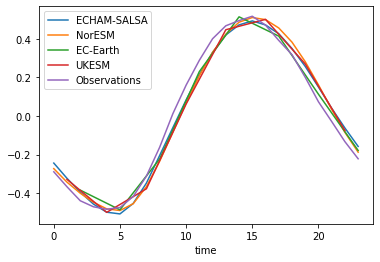

In [44]:
for m in models + ['Observations']:
    c = list(dic_df_pre[m].keys())[0]
    _df = dic_df_pre[m][c].copy(deep=True)
    #if m in ['NorESM','UKESM']:
    #    _df.index = _df.index -  datetime.timedelta(hours=1)
    #if m in ['ECHAM-SALSA','EC-Earth']:
    #    _df.index = _df.index -  datetime.timedelta(hours=0)

    print(m)
    if m=='Observations':
        a =_df.groupby(_df.index.hour).mean()['HYY_META.T168']
    else:
        a = _df.groupby(_df.index.hour).mean()['T_C'].dropna(axis=0)#.plot(marker='*',label=m)         
    ((a-a.mean())/(a.max()-a.min())).plot(label=m)         
    
plt.legend()
#plt.xlim(['2014-07','2014-08'])

### Controle that EC-Earth has correct time zone also for TM5 by checking that diurnal cycle of isoprene emissions and temperature align

In [45]:
m = 'EC-Earth'

EC-Earth


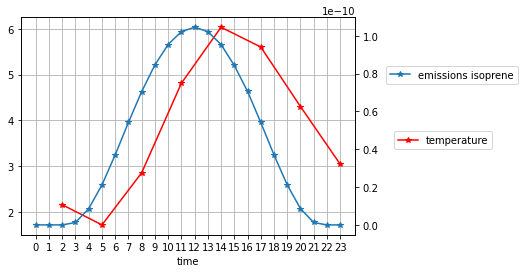

In [46]:
c = list(dic_df_pre[m].keys())[0]
_df = dic_df_pre[m][c]
print(m)
f, ax = plt.subplots()
_df.groupby(_df.index.hour).mean()['T_C'].dropna(axis=0).plot(marker='*',label='temperature', c='r')      
ax.legend(bbox_to_anchor=(1.1,.5,))
ax2 = ax.twinx()
_df.groupby(_df.index.hour).mean()['emiisop'].dropna(axis=0).plot(marker='*',label='emissions isoprene', ax=ax2)         
    
ax2.legend(bbox_to_anchor=(1,1.1,))
ax2.legend(bbox_to_anchor=(1.5,.8,))

ax.set_xticks(np.arange(24))
ax.grid()

## Timeseries

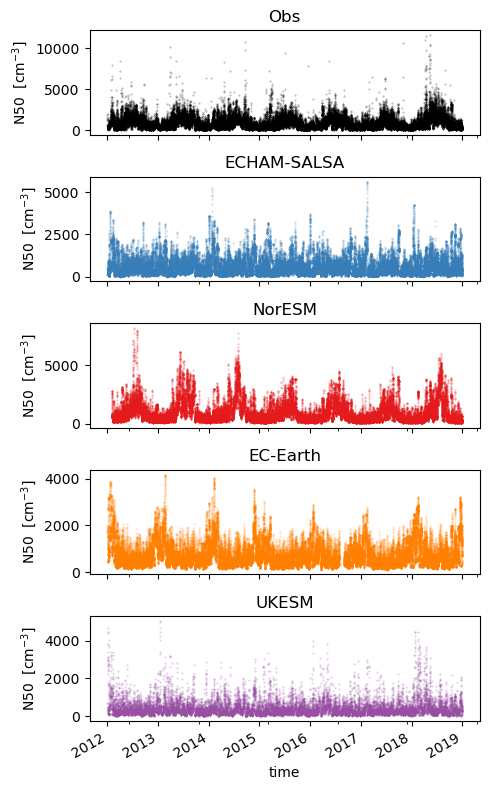

Plots/SMR/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_N50_timeseries_JA_SMR.png


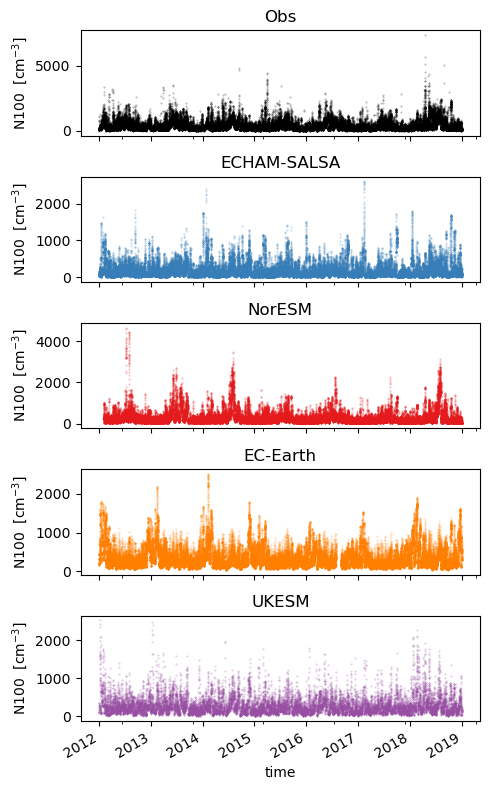

Plots/SMR/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_N100_timeseries_JA_SMR.png


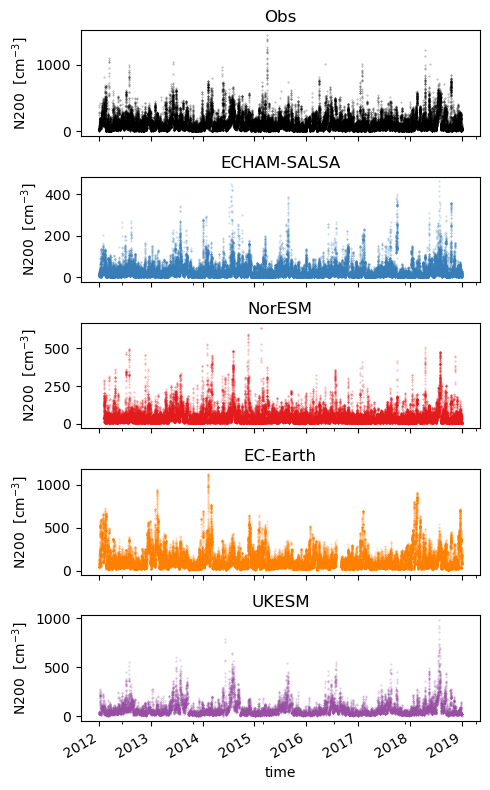

Plots/SMR/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_N200_timeseries_JA_SMR.png


In [47]:
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

seas = 'JA'
for i, v in enumerate(['N50','N100','N200']):
    fig, axs = plt.subplots(5,1, sharex=True, figsize=[5,8], dpi=100)
    
    #axs_sub = axs[:,i]
    #df_anom_Nx = dic[v]
    df_Nx = dic_Nx[v]

    #_df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(season2month[seas])]
    _df_Nx = df_Nx[df_Nx['Obs'].notna()]#.dropna(axis=0)
    #_df_anom_OA = _df_anom_OA[_df_anom_OA['Obs'].notna()] # .dropna(axis=0)

    for mo, ax in zip(df_anom_Nx.columns, axs):
        if mo=='Obs':
            c = 'k'
        else:
            c=cdic_model[mo]
            #continue
        ls = linestyle_dic[mo]
        _df = _df_Nx[mo].copy()
        #_df_gbm = _df_gb.median()
        #_df_gbstd = _df_gb.std()
        #_df_gb33 = _df_gb.quantile(.84)
        #_df_gb66 = _df_gb.quantile(.16)
        
        _df.plot(ax=ax,c=c,
             #linestyle=ls,
             marker='.', 
             linewidth=0,
             markersize=.7,
             alpha=.4,
             rasterized=True,
                 
             label=mo)
 
        ax.set_title(mo) 
        ax.set_ylabel('%s  [cm$^{-3}$]'%v)


        #ax.legend(frameon=False)

    #ax.set_xlabel('Time of day [h]')
    plt.tight_layout()
    plt.show()
    fn = make_fn_eval('_'.join(models), f'{v}_timeseries_{seas}')
    print(fn)

    #fig.savefig(fn.with_suffix('.png'))
    fig.savefig(fn.with_suffix('.pdf'))

## Choose months: 

In [48]:
df_Nx_all

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-01-01 02:00:00,87.040280,4.012207,NaN,NaN,NaN
2012-01-01 03:00:00,96.878629,4.509531,NaN,NaN,NaN
2012-01-01 04:00:00,117.824268,5.927438,NaN,NaN,32.331825
2012-01-01 08:00:00,386.072285,12.024642,NaN,178.059317,NaN
2012-01-01 09:00:00,366.063488,13.354135,NaN,189.390350,NaN
...,...,...,...,...,...
2018-12-31 21:00:00,35.610311,2.132461,25.636721,183.743172,NaN
2018-12-31 22:00:00,24.765184,1.667034,19.678599,173.977283,9.336049
2018-12-31 23:00:00,13.115932,1.462009,14.015061,172.111744,NaN


<AxesSubplot:xlabel='time'>

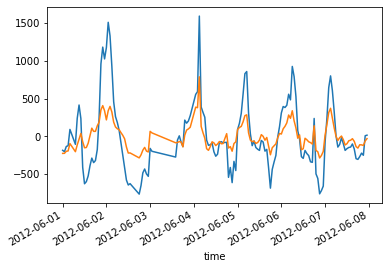

In [49]:
dic_anom_Nx['N50'].loc['2012-06-01':'2012-06-07']['Obs'].plot()

dic_anom_Nx['N100'].loc['2012-06-01':'2012-06-07']['Obs'].plot()

<AxesSubplot:xlabel='time'>

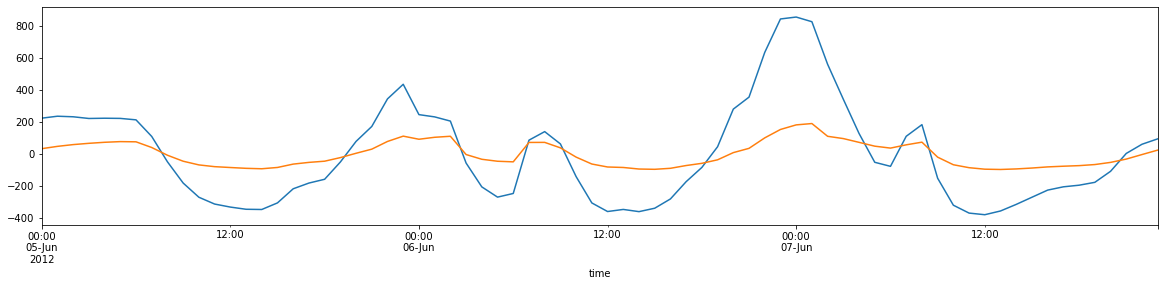

In [50]:
fig = plt.figure(figsize=[20,4])

dic_anom_Nx['N50'].loc['2012-06-05':'2012-06-07']['NorESM'].plot()

dic_anom_Nx['N100'].loc['2012-06-05':'2012-06-07']['NorESM'].plot()

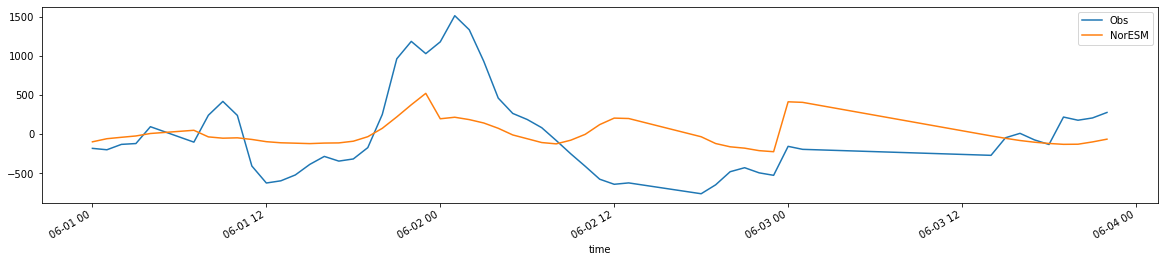

In [51]:
fig = plt.figure(figsize=[20,4])
dic_anom_Nx['N50'].loc['2012-06-01':'2012-06-03']['Obs'].plot()

dic_anom_Nx['N50'].loc['2012-06-01':'2012-06-03']['NorESM'].plot()
plt.legend()

In [52]:
dic_anom_Nx['N100']

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-01-01 02:00:00,-443.336783,-56.098018,NaN,NaN,NaN
2012-01-01 03:00:00,-414.689397,-53.141528,NaN,NaN,NaN
2012-01-01 04:00:00,-344.610448,-43.378896,NaN,NaN,-102.600906
2012-01-01 08:00:00,401.872691,6.981666,NaN,-67.198622,NaN
2012-01-01 09:00:00,477.531031,20.182326,NaN,-33.852779,NaN
...,...,...,...,...,...
2018-12-31 20:00:00,45.461338,-8.360493,32.853508,59.967767,NaN
2018-12-31 21:00:00,5.361902,-51.800053,13.052271,-36.728123,NaN
2018-12-31 22:00:00,-23.450044,-75.413698,-10.289563,-65.675803,-89.497995


In [53]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

N50
N100
N200
Plots/SMR/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_Nx_diurnal_mean_dev_JA_SMR.png


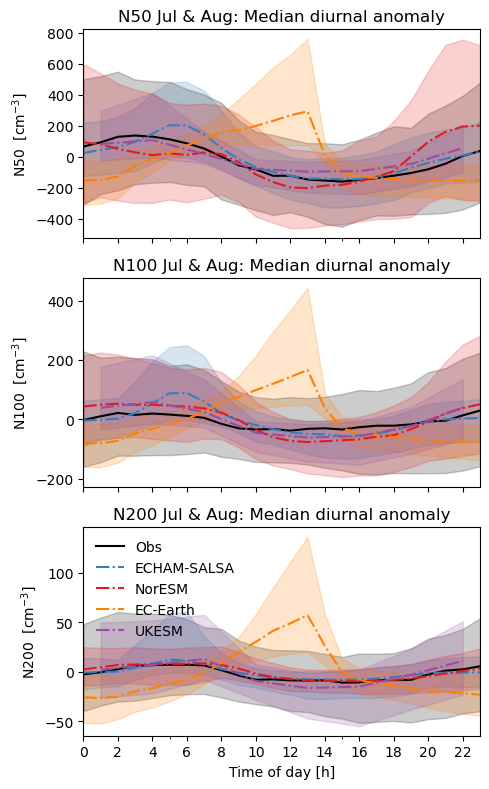

In [54]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=[5,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

seas = 'JA'
for v, ax in zip(['N50','N100','N200'], axs):
    print(v)
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(season2month[seas])].copy()
    _df_anom_Nx = _df_anom_Nx[_df_anom_Nx['Obs'].notna()]
    
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod in ['UKESM','EC-Earth']:
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{v} Jul & Aug: Median diurnal anomaly") 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)


ax.legend(frameon=False)

plt.legend(frameon=False)
ax.set_xlabel('Time of day [h]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'Nx_diurnal_mean_dev_{seas}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

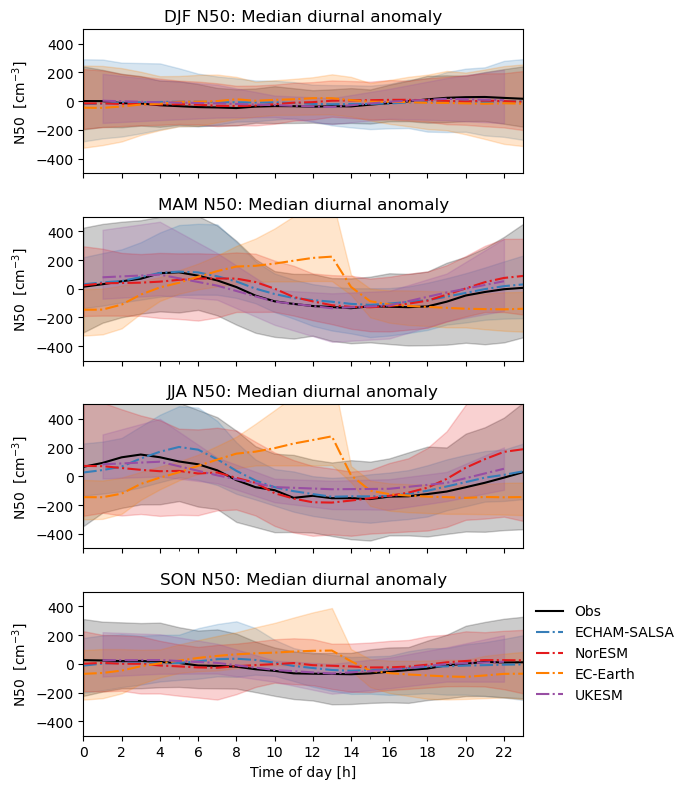

In [55]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N50'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])]
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    ax.set_ylim([-500,500])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

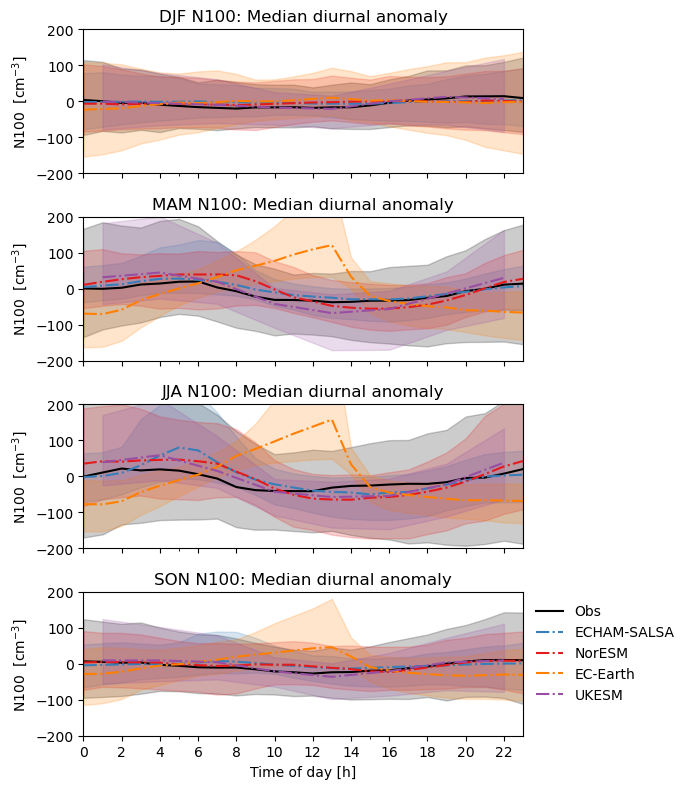

In [56]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N100'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])]
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    ax.set_ylim([-200,200])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

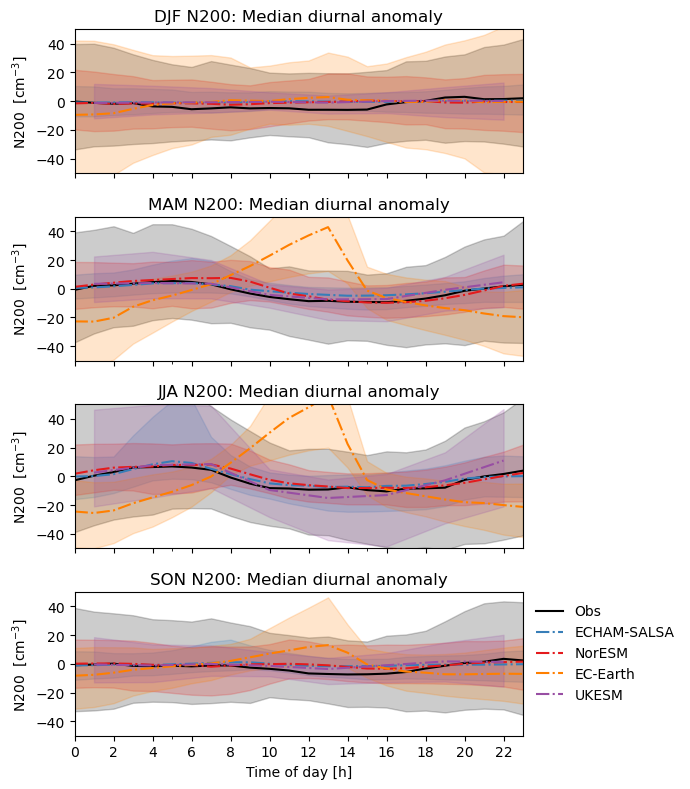

In [57]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N200'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])]
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    ax.set_ylim([-50,50])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

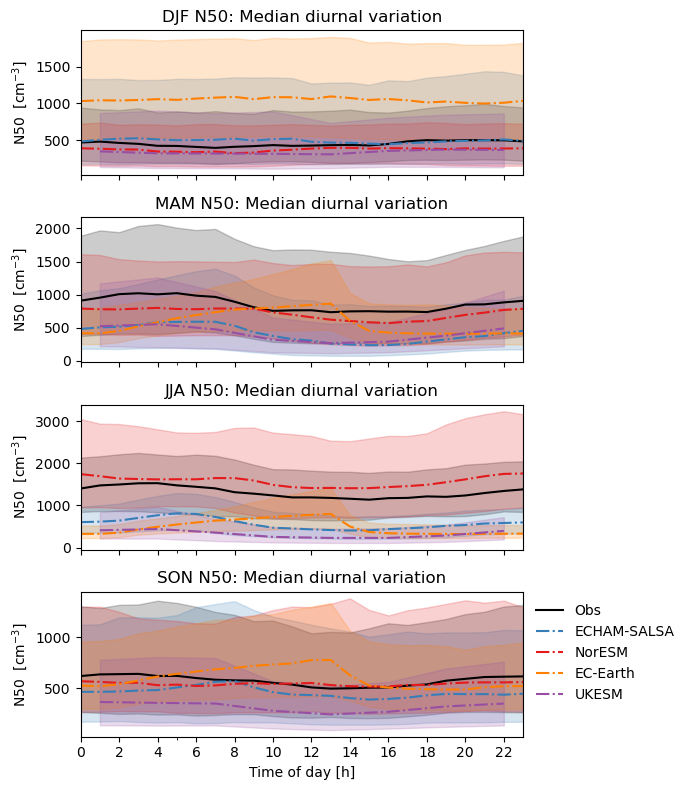

In [58]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N50'

for seas, ax in zip(seasons2months, axs):
    df_Nx = dic_Nx[v]
    _df_Nx = df_Nx[df_Nx.index.month.isin(seasons2months[seas])]
    
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]


        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                     linestyle=ls,
                     label=mod,
                    )
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal variation") 

    #ax.set_ylim([-3,3])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

#for ax in axs: 
#    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'diurnal_mean_{v}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

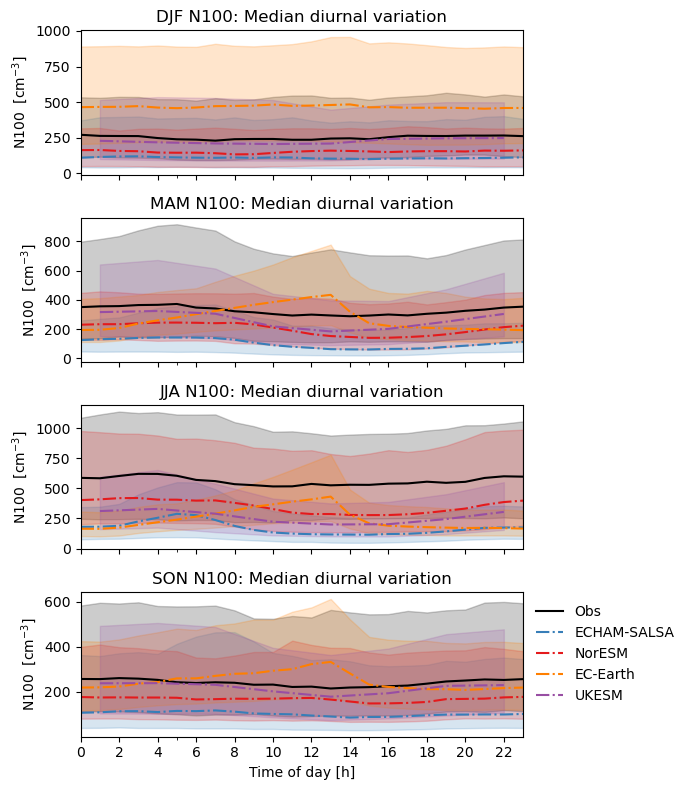

In [59]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N100'

for seas, ax in zip(seasons2months, axs):
    df_Nx = dic_Nx[v]
    _df_Nx = df_Nx[df_Nx.index.month.isin(seasons2months[seas])]
    
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]
        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                     linestyle=ls,
                     label=mod,
                    )
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal variation") 

    #ax.set_ylim([-3,3])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

#for ax in axs: 
#    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'diurnal_mean_{v}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

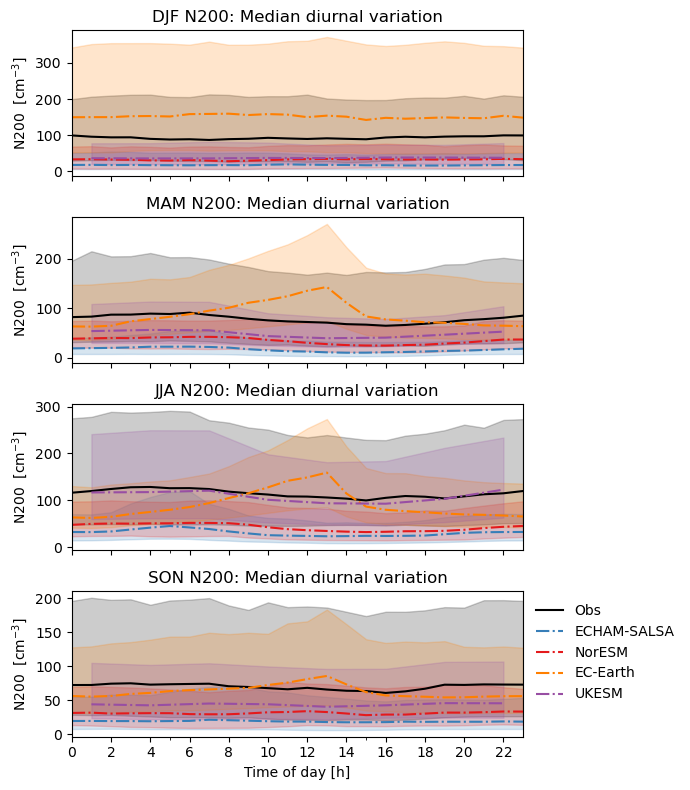

In [60]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')
v = 'N200'
for seas, ax in zip(seasons2months, axs):
    df_Nx = dic_Nx[v]
    _df_Nx = df_Nx[df_Nx.index.month.isin(seasons2months[seas])]
    
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]
        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                     linestyle=ls,
                     label=mod,
                    )
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal variation") 

    #ax.set_ylim([-3,3])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

#for ax in axs: 
#    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'diurnal_mean_{v}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

Plots/SMR/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_annual_median_Nx_SMR.png


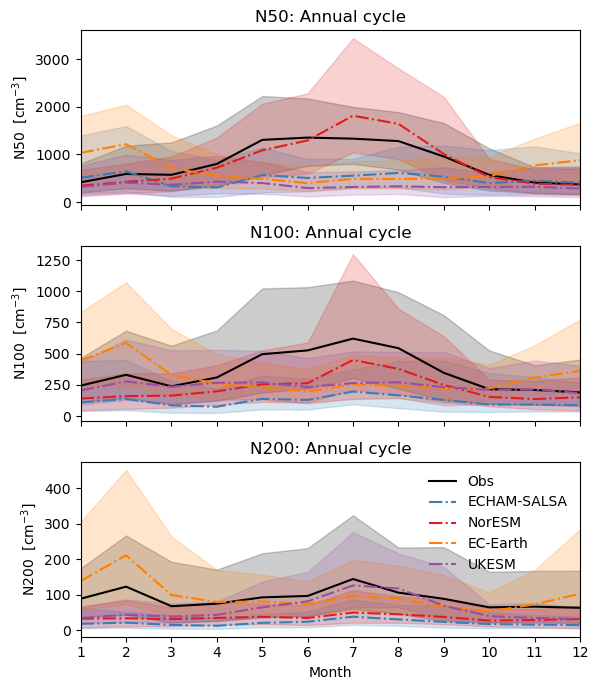

In [61]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=[6,7], dpi=100)
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')
v = 'N50'
for v,ax in zip(['N50', 'N100','N200'], axs):  
    _df_Nx = dic_Nx[v]
    _df_Nx = _df_Nx.dropna(axis=0)
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
        #if mod=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.month)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
    
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
        # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{v}: Annual cycle") 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)


ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Month')
#ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks(np.arange(1,13))

ax.set_xlim([1,12])
fn = make_fn_eval('_'.join(models), 'annual_median_Nx')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

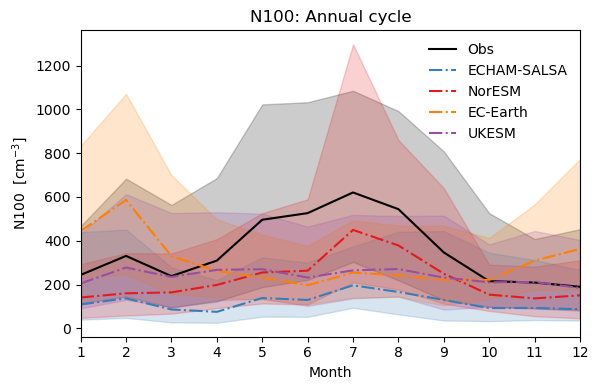

In [62]:
fig, axs = plt.subplots(1,1, sharex=True, figsize=[6,4], dpi=100)
ax = axs
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')
v = 'N100'
    
_df_Nx = dic_Nx[v]
_df_Nx = _df_Nx.dropna(axis=0)
for mod in df_Nx.columns:
    if mod=='Obs':
        c = 'k'
    else:
        c=cdic_model[mod]
    ls = linestyle_dic[mod]
    _df_gb = _df_Nx[mod].groupby(_df_Nx.index.month)
    _df_gbm = _df_gb.median()
    _df_gbstd = _df_gb.std()
    _df_gb33 = _df_gb.quantile(.84)
    _df_gb66 = _df_gb.quantile(.16)
    
    _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
    ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
ax.set_title(f"{v}: Annual cycle") 

#ax.set_ylim([0,4])

ax.legend(frameon=False)
ax.set_ylabel('%s  [cm$^{-3}$]'%v)


plt.legend(frameon=False)
ax.set_xlabel('Month')
#ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks(np.arange(1,13))

ax.set_xlim([1,12])
fn = make_fn_eval('_'.join(models), 'diurnal_mean')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

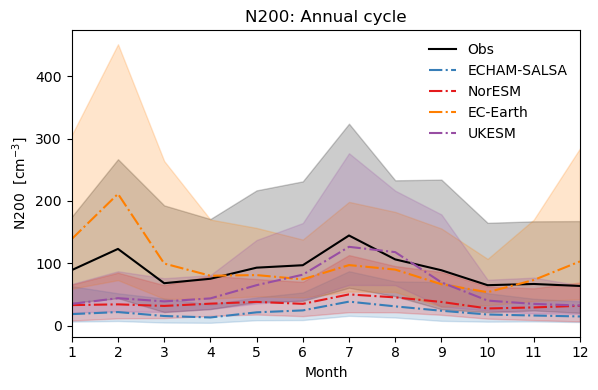

In [63]:
fig, axs = plt.subplots(1,1, sharex=True, figsize=[6,4], dpi=100)
ax = axs
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')
v = 'N200'
    
_df_Nx = dic_Nx[v]
_df_Nx = _df_Nx.dropna(axis=0)
for mod in df_Nx.columns:
    if mod=='Obs':
        c = 'k'
    else:
        c=cdic_model[mod]
    ls = linestyle_dic[mod]
    _df_gb = _df_Nx[mod].groupby(_df_Nx.index.month)
    _df_gbm = _df_gb.median()
    _df_gbstd = _df_gb.std()
    _df_gb33 = _df_gb.quantile(.84)
    _df_gb66 = _df_gb.quantile(.16)
    
    _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
    ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
ax.set_title(f"{v}: Annual cycle") 

#ax.set_ylim([0,4])

ax.legend(frameon=False)
ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.legend(frameon=False)
ax.set_xlabel('Month')
#ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks(np.arange(1,13))

ax.set_xlim([1,12])
fn = make_fn_eval('_'.join(models), 'diurnal_mean')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

In [64]:
import matplotlib as mpl

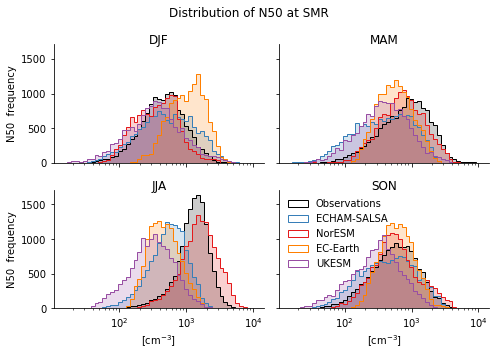

In [65]:
v = 'N50'
df_Nx = dic_Nx[v]

mi = np.min(df_Nx[df_Nx['Obs']>0]['Obs'])
ma = np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

fig, axs = plt.subplots(2,2,figsize = [7,5,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months, axs.flatten()):
    df_Nx_sub = df_Nx[df_Nx.index.month.isin(seasons2months[seas])].copy()
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                histtype='step',
                                    )
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                    )

    for mo in models:
        #if mo=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # only 3 hourly resolution
            df_Nx_sub.loc[:,mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)
        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )
    ax.set_xscale('log')
    #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')
    ax.set_ylabel('%s  frequency'%v)
    ax.set_xlabel('[cm$^{-3}$]')

    # ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

ax.legend(frameon=False)
plt.suptitle(f'Distribution of {v} at {select_station}')
fn = make_fn_eval('noresm_echam_seasons',f'hist_{v}')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

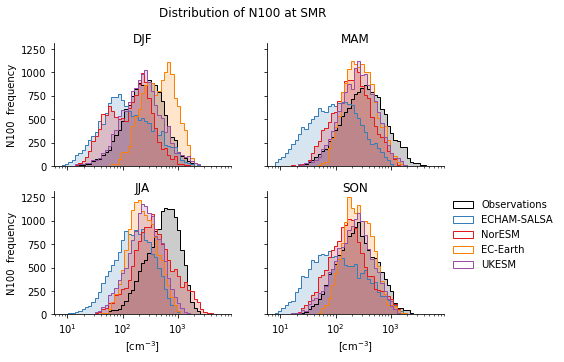

In [66]:
v = 'N100'
df_Nx = dic_Nx[v]

mi = np.min(df_Nx[df_Nx['Obs']>0]['Obs'])
ma = np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

fig, axs = plt.subplots(2,2,figsize = [7,5,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months, axs.flatten()):
    df_Nx_sub = df_Nx[df_Nx.index.month.isin(seasons2months[seas])].copy()
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                histtype='step',
                                    )
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                    )

    for mo in models:
        #if mo=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # only 3 hourly resolution
            df_Nx_sub[mo] =df_Nx_sub.loc[:,mo].ffill(limit=3).copy()

        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )
    ax.set_xscale('log')
    ax.set_ylabel('%s  frequency'%v)
    ax.set_xlabel('[cm$^{-3}$]')

    # ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

leg = ax.legend(frameon=False, bbox_to_anchor=(1,1,))
plt.suptitle(f'Distribution of {v} at {select_station}')
fn = make_fn_eval('noresm_echam_seasons',f'hist_{v}')
#fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300, bbox_inches='tight')


plt.savefig(fn.with_suffix('.pdf'), dpi=300, bbox_inches='tight')

[]('Plots/SMR/evalNx_echam_noresm_echam_seasons_hist_N100_SMR.png')

[Plots/SMR/evalNx_echam_noresm_echam_seasons_hist_N100_SMR.png]

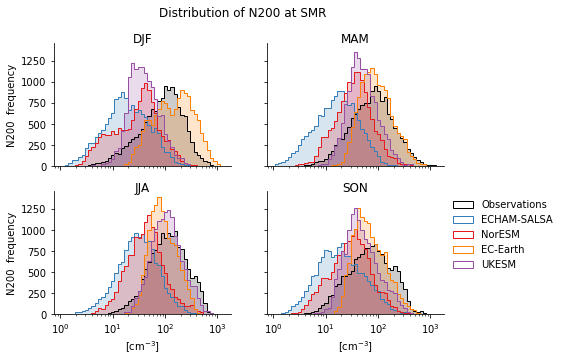

In [67]:
v = 'N200'
df_Nx = dic_Nx[v]

mi = np.min(df_Nx[df_Nx['Obs']>0]['Obs'])
ma = np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

fig, axs = plt.subplots(2,2,figsize = [7,5,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months, axs.flatten()):
    df_Nx_sub = df_Nx[df_Nx.index.month.isin(seasons2months[seas])].copy()
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                histtype='step',
                                    )
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                    )

    for mo in models:
        #if mo=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # only 3 hourly resolution
            df_Nx_sub[mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)

        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )
    ax.set_xscale('log')
    ax.set_ylabel('%s  frequency'%v)
    ax.set_xlabel('[cm$^{-3}$]')

    # ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

leg = ax.legend(frameon=False, bbox_to_anchor=(1,1,))
plt.suptitle(f'Distribution of {v} at {select_station}')
fn = make_fn_eval('noresm_echam_seasons',f'hist_{v}')
#fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300, bbox_inches='tight')


plt.savefig(fn.with_suffix('.pdf'), dpi=300, bbox_inches='tight')

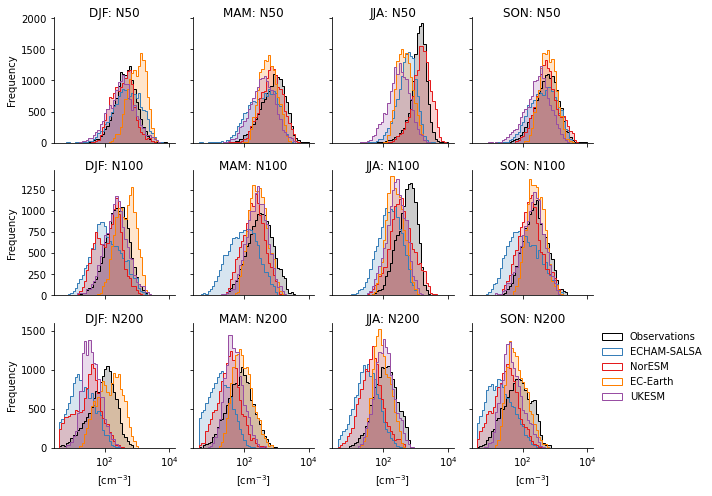

In [68]:
fig, axs_all = plt.subplots(3,4,figsize = [10,7,],sharex=True, sharey='row')

mi = 4#np.min(df_Nx[df_Nx['Obs']>0]['Obs'])*300
ma = 1e4#np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

for i, v in enumerate(['N50','N100','N200']):
    df_Nx = dic_Nx[v]
    axs = axs_all[i,:]




    for seas,ax in zip(seasons2months, axs.flatten()):
        
        df_Nx_sub = df_Nx[df_Nx.index.month.isin(seasons2months[seas])].copy()
        df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                histtype='step',
                                    )
        df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                    )


        for mo in models:
            #if mo=='UKESM':
            if mod in ['UKESM','EC-Earth']:
                
                # only 3 hourly resolution
                df_Nx_sub[mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)


            df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
            df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )
        ax.set_xscale('log')
        #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')
        ax.set_xlabel('[cm$^{-3}$]')

        # ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

        ax.set_title(f'{seas}: {v}', y=.95)

ax.legend(frameon=False, bbox_to_anchor=(1,1,))
#plt.suptitle(f'Distribution of {v} at {select_station}')
fn = make_fn_eval('noresm_echam_seasons',f'hist_seas_Nx')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300,bbox_inches='tight')


plt.savefig(fn.with_suffix('.pdf'), dpi=300,bbox_inches='tight')

In [69]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

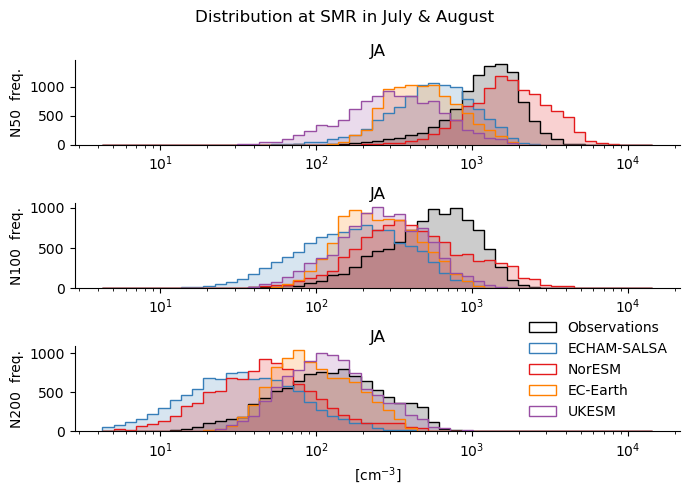

In [70]:
seas ='JA'


mi = np.min(df_Nx[df_Nx['Obs']>0]['Obs'])*4
ma = np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*10
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)
v = 'N200'
fig, axs = plt.subplots(3,1,figsize = [7,5,],dpi=100)

for v, ax in zip(['N50','N100','N200'], axs):
    df_Nx = dic_Nx[v]

    df_Nx_sub = df_Nx[df_Nx.index.month.isin(season2month[seas])].copy()
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                histtype='step',
                                    )
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                    )

    for mo in models:
        #if mo=='UKESM':
        if mod in ['UKESM','EC-Earth']:
            
            # only 3 hourly resolution
            df_Nx_sub[mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)

        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )

    ax.set_xscale('log')
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
    ax.set_title(f'{seas}', y=.95)
    ax.set_ylabel('%s  freq.'%v)
ax.set_xlabel('[cm$^{-3}$]')

ax.legend(frameon=False)
fig.suptitle(f'Distribution at {select_station} in July & August')

fn = make_fn_eval('noresm_echam_JA','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300,bbox_inches='tight')


plt.savefig(fn.with_suffix('.pdf'), dpi=300,bbox_inches='tight')

Plots/SMR/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_2dist_Nx_conc_SMR.png


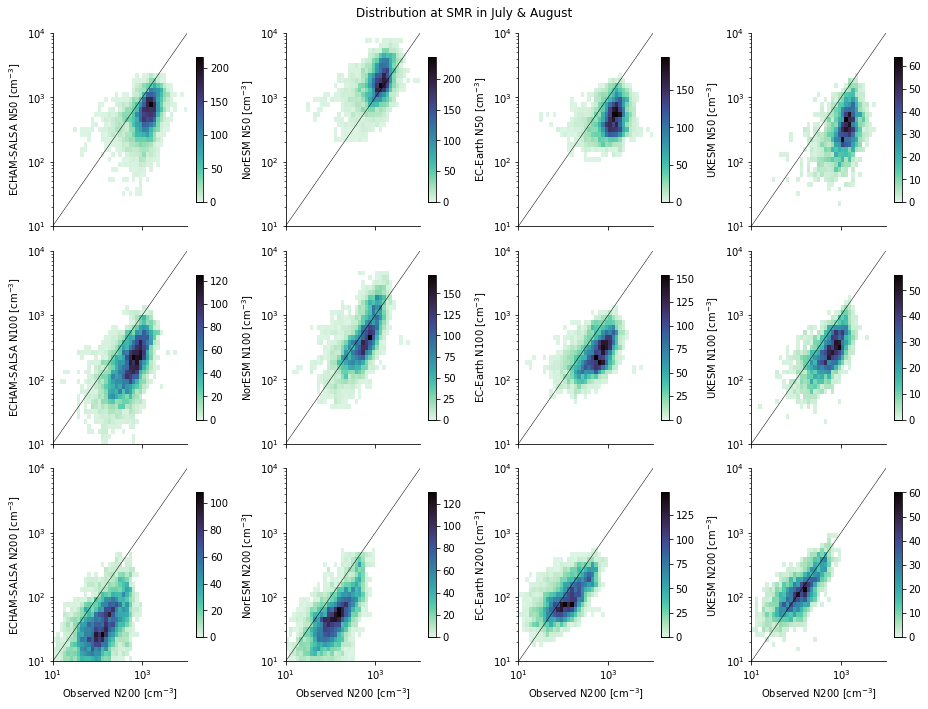

In [71]:
fig, axs = plt.subplots(3,4,figsize = [13,10],sharex=True, sharey=False)
seas = 'JA'
for i, v in enumerate(['N50','N100','N200']):
    #v = 'N100'
    _df_Nx = dic_Nx[v]
    _df = _df_Nx[_df_Nx.index.month.isin(season2month[seas])].copy()
    _df['hour'] = _df.index.hour
    axs_sub = axs[i,:]
    bins = np.linspace(1,4,40)

    for mo, ax in zip(models,axs_sub):
        sns.histplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e1,1e4])
        ax.set_xlim([1e1,1e4])
        ax.set_xscale('log')

        ax.set_ylabel(f'{mo} {v} '+'[cm$^{-3}$]')
        ax.set_xlabel(f'Observed {v} '+'[cm$^{-3}$]')



        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)
fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),'2dist_Nx_conc')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)
print(fn)

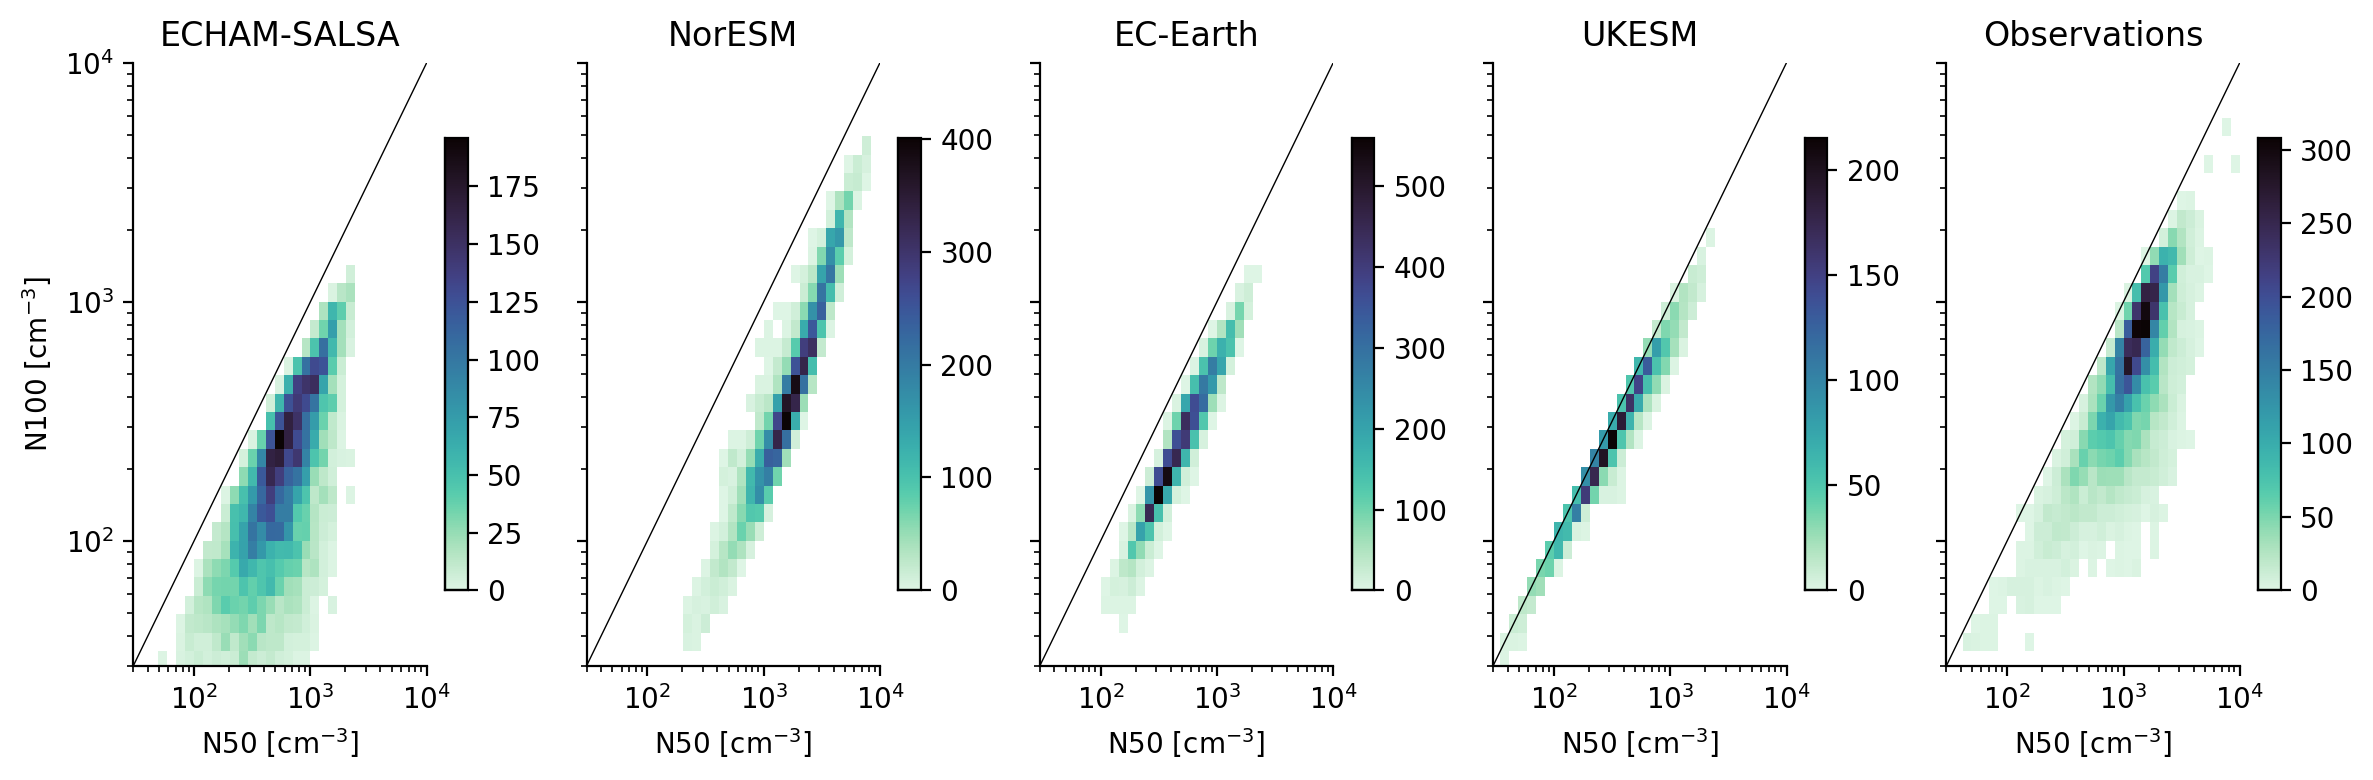

In [72]:
fig, axs = plt.subplots(1,5,figsize = [12,4],sharex=True, sharey=True, dpi=200)
seas = 'JA'
vx = 'N50'
vy = 'N100'
for i, mo in enumerate(dic_df_mod_case.keys()):
    
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]].copy()
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])].copy()
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(1,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([3e1,1e4])
    ax.set_xlim([3e1,1e4])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

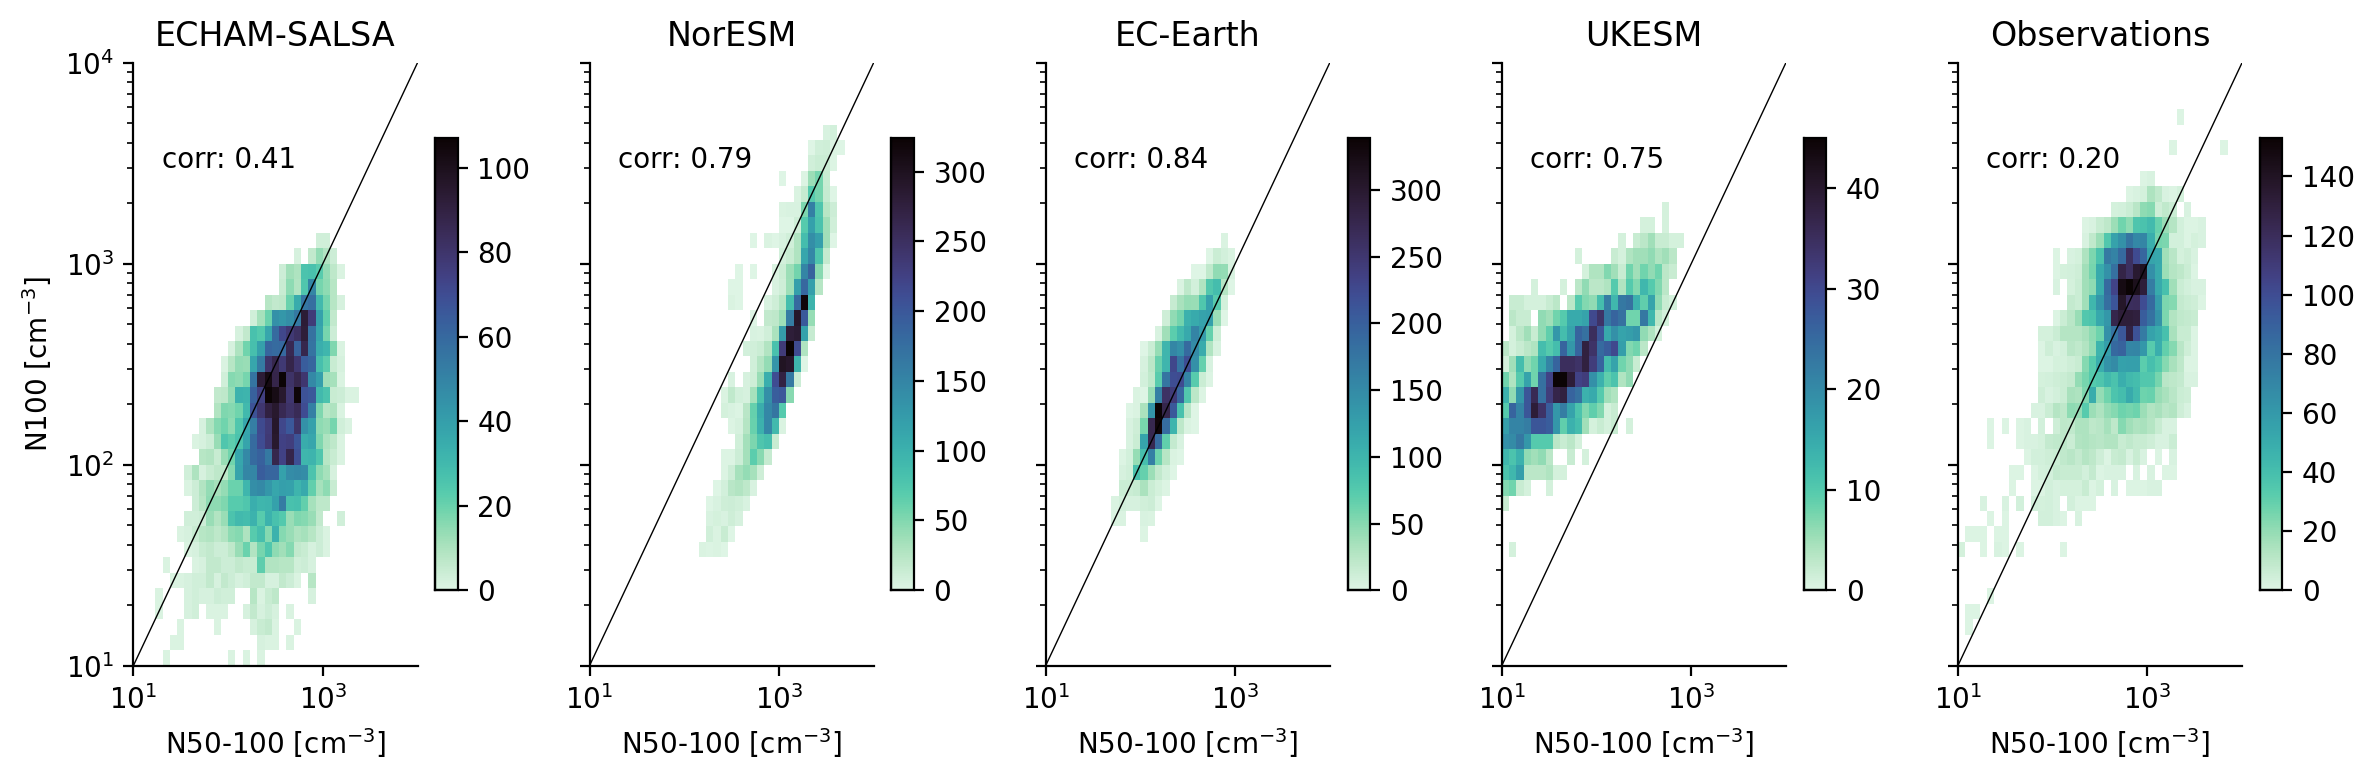

In [73]:
fig, axs = plt.subplots(1,5,figsize = [12,4],sharex=True, sharey=True, dpi=200)
seas = 'JA'
vy = 'N100'
vx = 'N50-100'
for i, mo in enumerate(dic_df_mod_case.keys()):
    
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]].copy()
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])].copy()
    _df_shifted = _df.copy()
    _df_shifted.index = _df.index - datetime.timedelta(hours=0)
    
    _df['N50-100'] = _df_shifted['N50'] - _df_shifted['N100']
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(1,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)
    corr = _df[[vx,vy]].corr().loc[vx,vy]
    ax.text(2e1,3e3,f'corr: {corr:.2f}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e1,1e4])
    ax.set_xlim([1e1,1e4])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

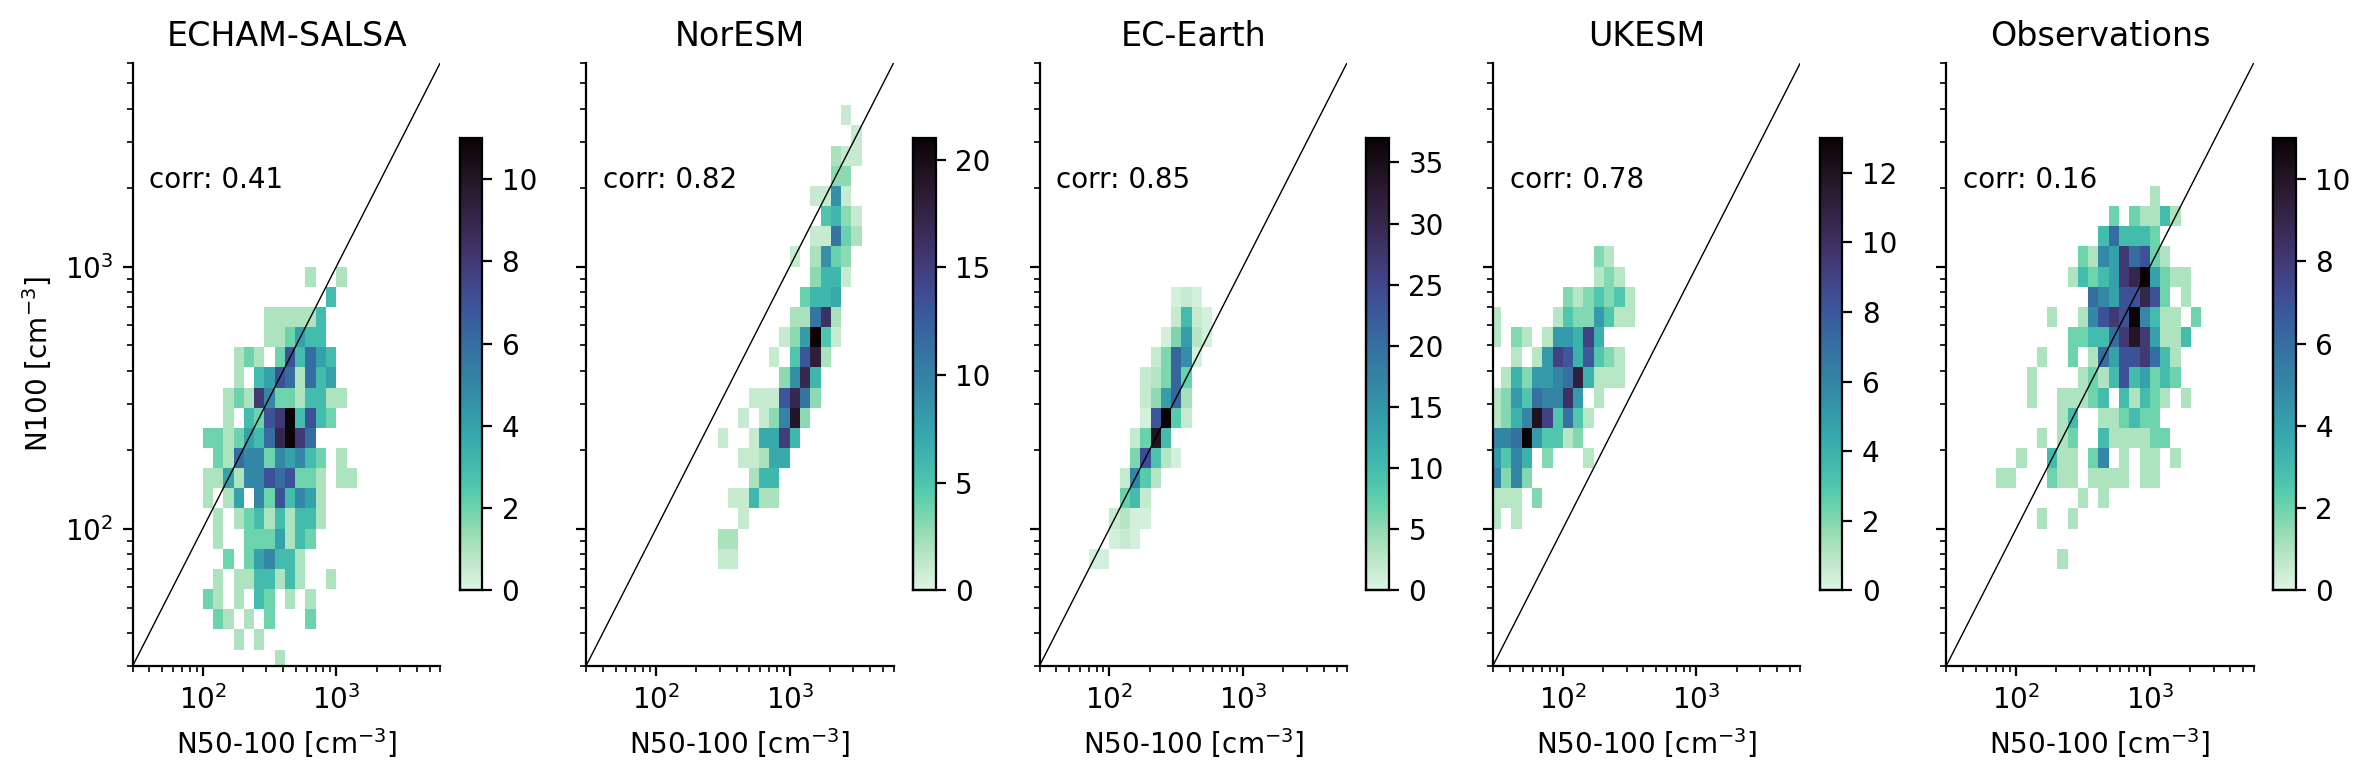

In [74]:
fig, axs = plt.subplots(1,5,figsize = [12,4],sharex=True, sharey=True, dpi=200)
seas = 'JA'
vy = 'N100'
vx = 'N50-100'
for i, mo in enumerate(dic_df_mod_case.keys()):
    
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]].copy()
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])].copy().resample('d').mean()
    _df['N50-100'] = _df['N50'] - _df['N100']
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(1,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)
    corr = _df[[vx,vy]].corr().loc[vx,vy]
    ax.text(4e1,2e3,f'corr: {corr:.2f}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([3e1,6e3])
    ax.set_xlim([3e1,6e3])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

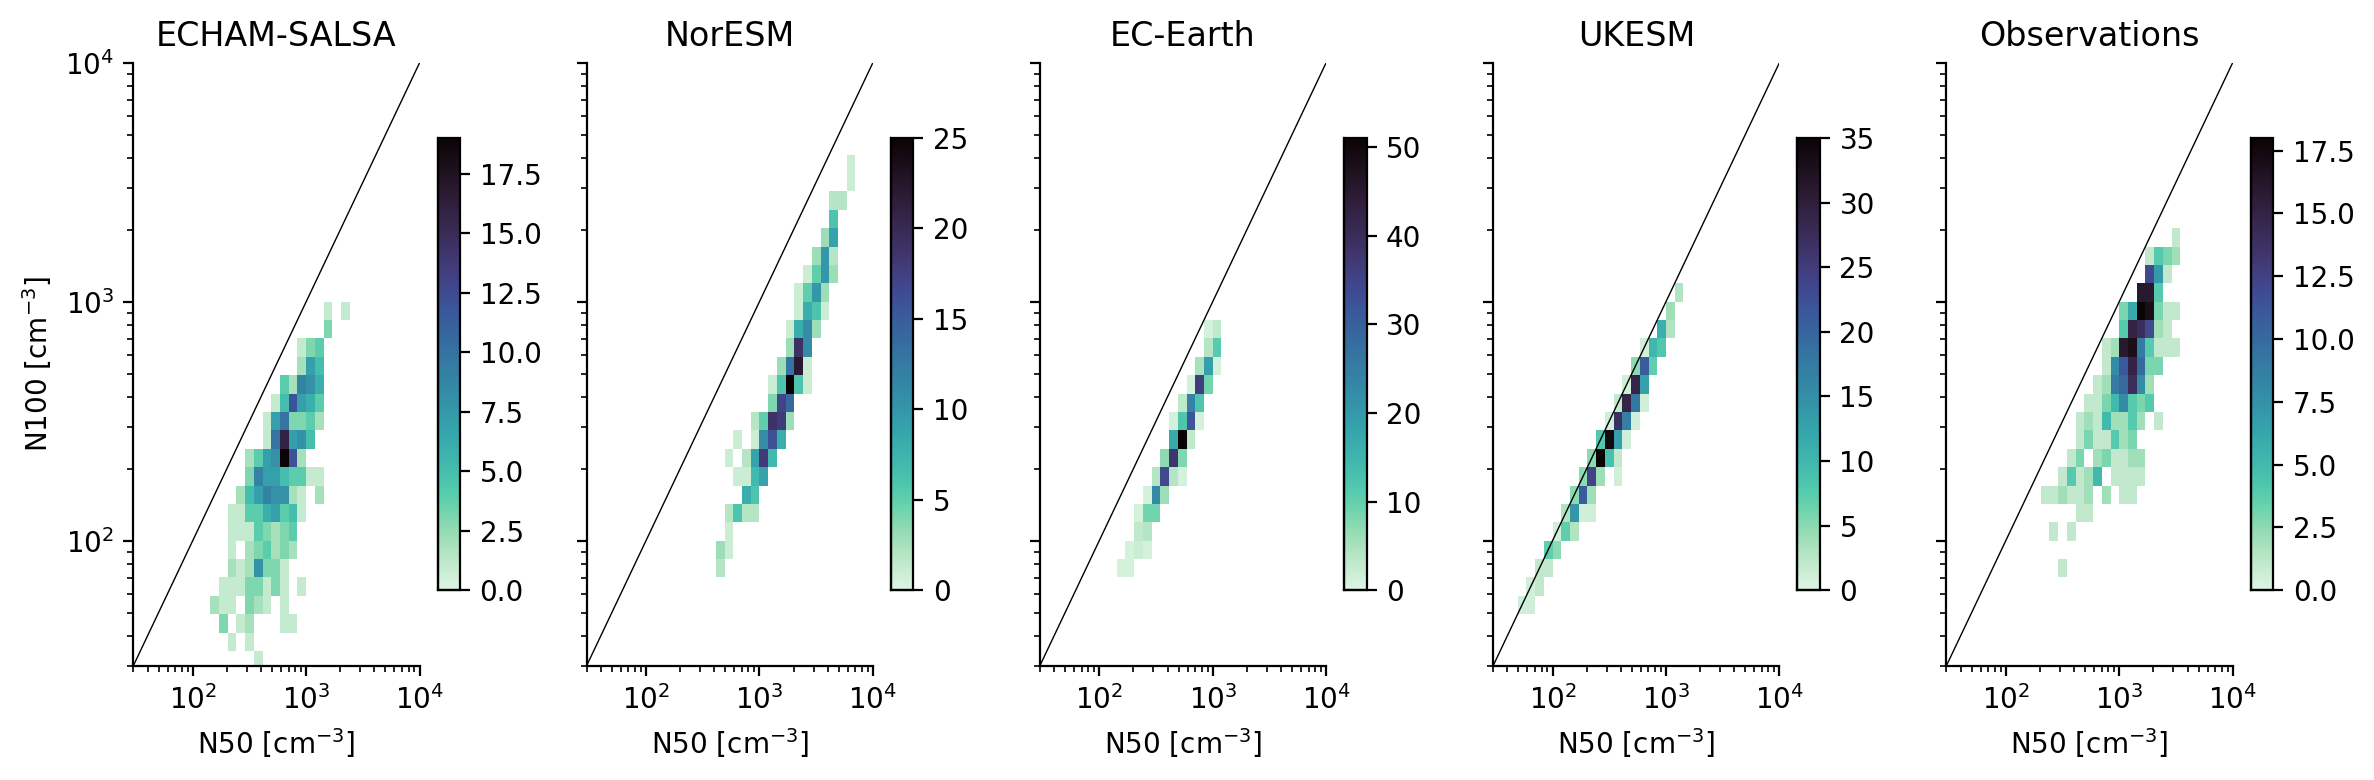

In [75]:
fig, axs = plt.subplots(1,5,figsize = [12,4],sharex=True, sharey=True, dpi=200)
seas = 'JA'
vx = 'N50'
vy = 'N100'
for i, mo in enumerate(dic_df_mod_case.keys()):
    
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]].copy()
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])].copy().resample('d').mean()
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(1,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([3e1,1e4])
    ax.set_xlim([3e1,1e4])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

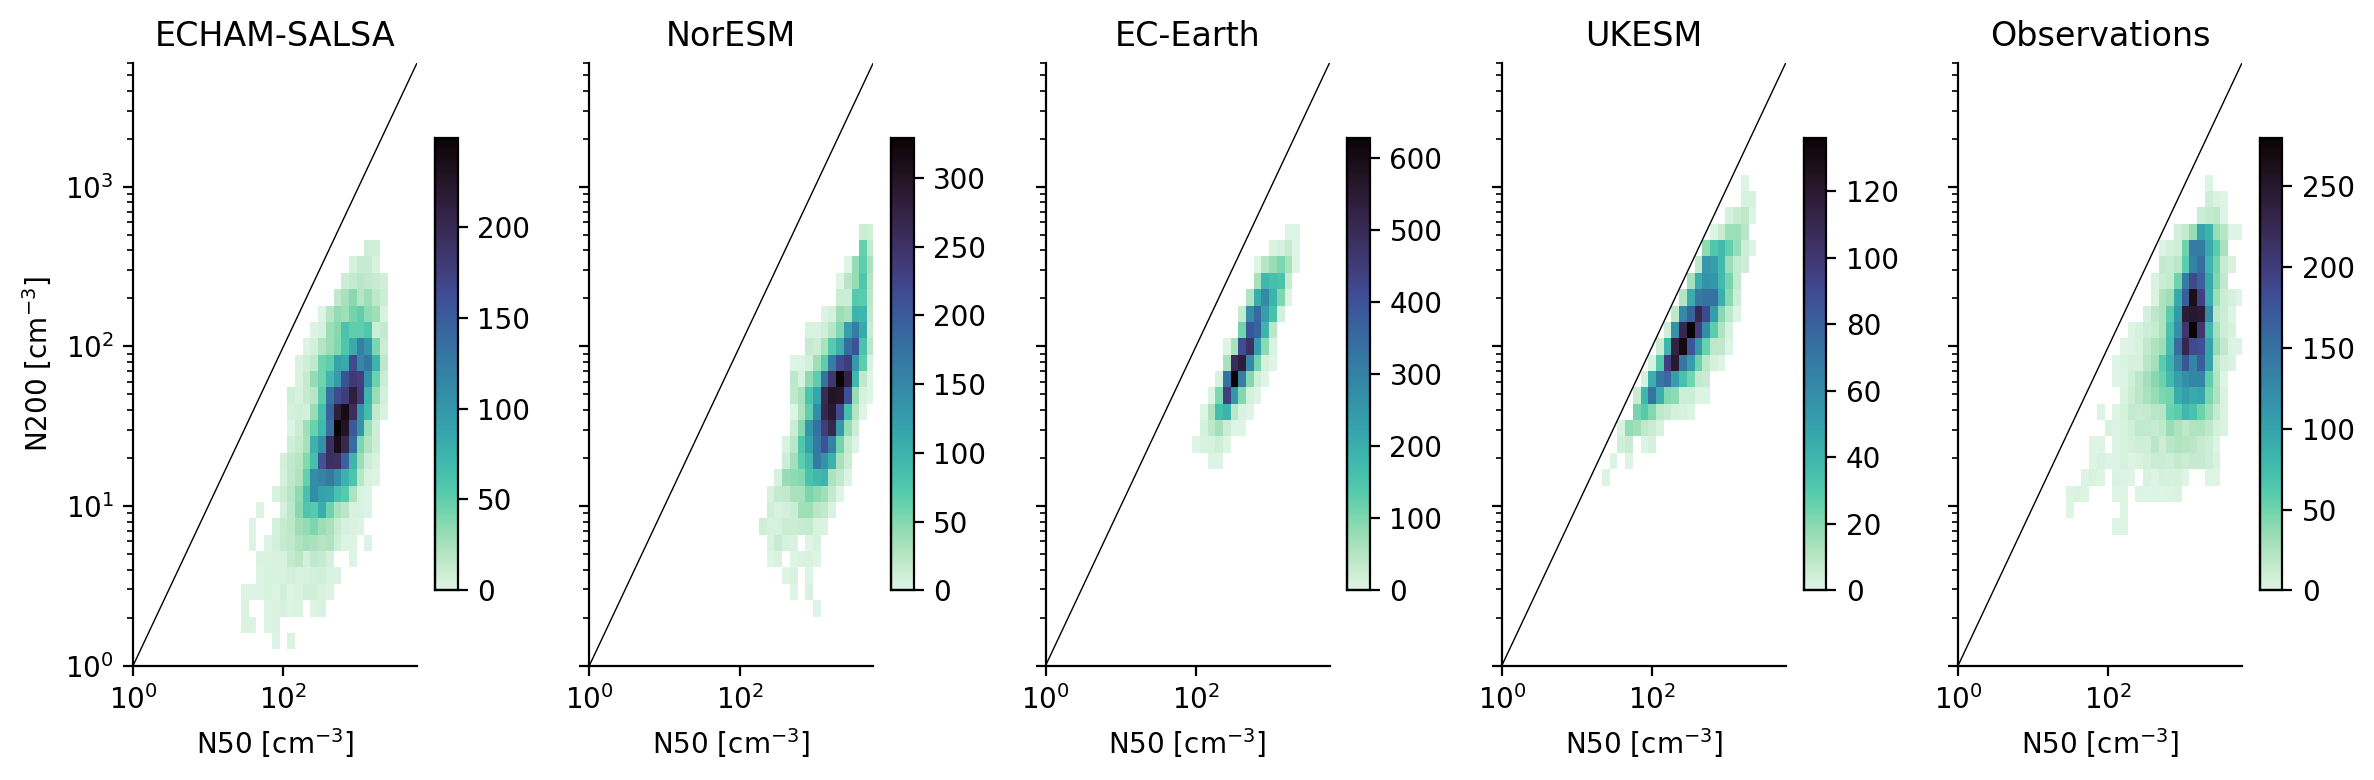

In [76]:
fig, axs = plt.subplots(1,5,figsize = [12,4],sharex=True, sharey=True, dpi=200)
seas = 'JA'
vx = 'N50'
vy = 'N200'
for i, mo in enumerate(dic_df_mod_case.keys()):
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]]
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])]
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(0,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e0,6e3])
    ax.set_xlim([1e0,6e3])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

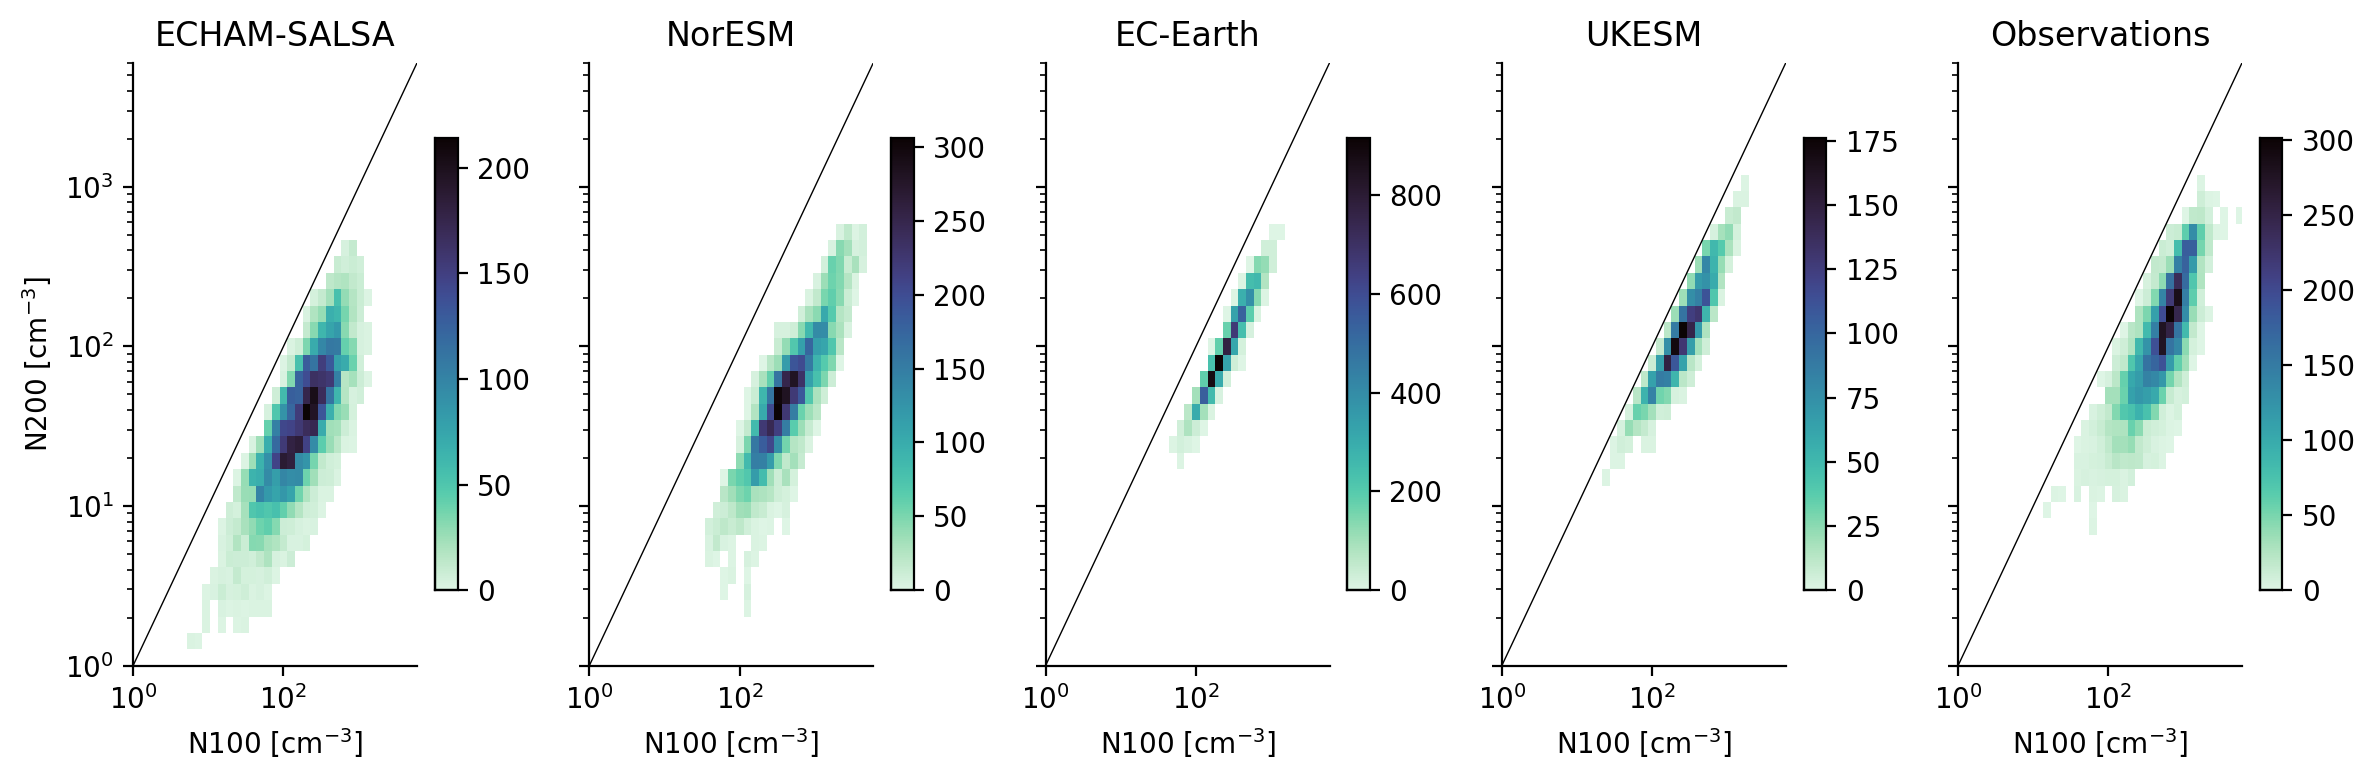

In [77]:
fig, axs = plt.subplots(1,5,figsize = [12,4],sharex=True, sharey=True, dpi=200)
seas = 'JA'
vx = 'N100'
vy = 'N200'
for i, mo in enumerate(dic_df_mod_case.keys()):
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]]
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])]
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(0,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e0,6e3])
    ax.set_xlim([1e0,6e3])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)